In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append('../')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.interpolate import RegularGridInterpolator, splrep, splev, InterpolatedUnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
import gc
gc.enable()
from settings import *

In [4]:
plot_sets = {
    '10yr IceCube': {"color": "purple", "ls": ":"},
    '40yr IceCube': {"color": "tab:orange", "ls": "--"},
    '10yr Plenum': {"color": "teal", "ls": "-"}
}

# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


In [6]:
# with three dimensions: sindec, energy, ra
aeff_eval = lambda aeff: ((aeff * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width)
# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

### background

In [7]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

## Icecube energy x sindec
### comparison to diffuse (only northern) should yield ~600k events, ~2700 astro

In [8]:
# check
for det in ["IceCube", "Plenum"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det]) * LIVETIME
    astro_ev = aeff_factor * (emids/1E5)**(GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 628697.8636805005
astro events: 2337.4935266970087
Plenum
conv events: 2527942.6014167126
astro events: 9348.156419418276


### nice plot

Text(0, 0.5, '$\\sin(\\delta)$')

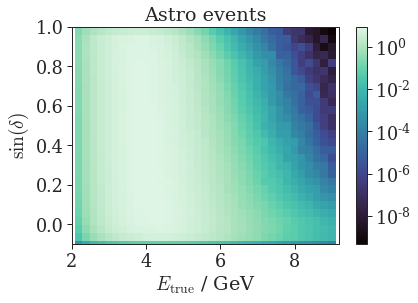

In [9]:
label = "10yr IceCube"
aeff_factor = aeff_eval_e_sd(aeff_2d[label.split(" ")[-1]]) * LIVETIME
astro_ev = aeff_factor * (emids/1E5)**(GAMMA_ASTRO) * PHI_ASTRO

f, ax = plt.subplots()
im = ax.pcolormesh(
    log_emids,
    sindec_bins,
    astro_ev,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax)
ax.set_ylim(-0.1, 1)
ax.set_xlim(2, 9.2)
ax.set_title("Astro events")
ax.set_xlabel(r"$E_{\rm true}$ / GeV")
ax.set_ylabel(r"$\sin(\delta)$")

# energy and angular smearing

In [10]:
public_data_hist = np.genfromtxt(
    "../icecube_10year_ps/irfs/IC86_II_smearing.csv",
    skip_header=1
)
# #   0                    1                    2                  3                4                 5 
# #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]  log10(E/GeV)_min  log10(E/GeV)_max
# #   6                7            8               9                 10
# #  PSF_min[deg]  PSF_max[deg]  AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts

### point spread function

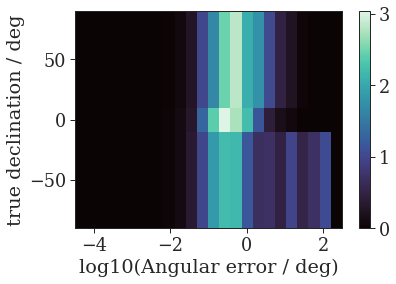

In [11]:
sm_dec_min, sm_dec_max = public_data_hist[:,2], public_data_hist[:,3]
sm_dec_mids = (sm_dec_min + sm_dec_max) / 2.

log_psf_min, log_psf_max = np.log10(public_data_hist[:,6]), np.log10(public_data_hist[:,7])
log_psf_mids = (log_psf_min + log_psf_max) / 2.

fractional_event_counts = public_data_hist[:,-1]
dec_binning = np.array([-90, -10, 10, 90])
log_psf_binning = np.linspace(-4.5, 2.5, 25)

## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    sm_dec_mids,
    (log_psf_binning, dec_binning),
    weights = fractional_event_counts,
    #norm = LogNorm()
)
#plt.xscale("log")
plt.ylabel("true declination / deg")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

### energy

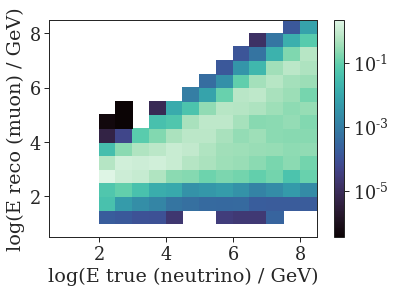

In [12]:
log_sm_emin, log_sm_emax = public_data_hist[:,0], public_data_hist[:,1]
log_sm_emids = (log_sm_emin + log_sm_emax) / 2.

log_sm_ereco_min, log_sm_ereco_max = public_data_hist[:,4], public_data_hist[:,5]
log_sm_ereco_mids = (log_sm_ereco_min + log_sm_ereco_max) / 2.

fractional_event_counts = public_data_hist[:,-1]
ebinning = np.arange(0.5, 9, 0.5)

## visualization
# original binning
_ = plt.hist2d(
    log_sm_emids,
    log_sm_ereco_mids,
    ebinning,
    weights = fractional_event_counts,
    norm = LogNorm()
)
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")
plt.colorbar()

# energy kde

In [13]:
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    kvals = pickle.load(f)

In [14]:
eri = calc_mids(np.arange(0.5, 9, 0.2))
# log_emids are the same as for effective area binning
ee, rr = np.meshgrid(log_emids, eri)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

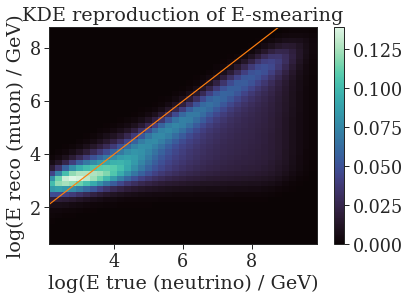

In [15]:
plt.pcolormesh(
    ee,
    rr,
    kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

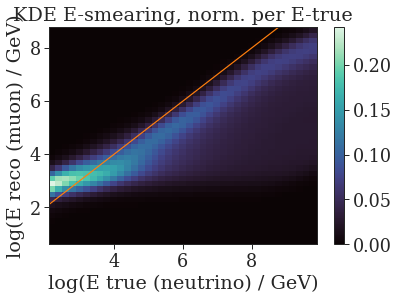

In [16]:
normed_kvals = kvals/np.sum(kvals, axis=0)
plt.pcolormesh(
    ee,
    rr,
    normed_kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE E-smearing, norm. per E-true")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### show aeff in true energy and reco energy

Text(0, 0.5, '$\\sin(\\delta)$')

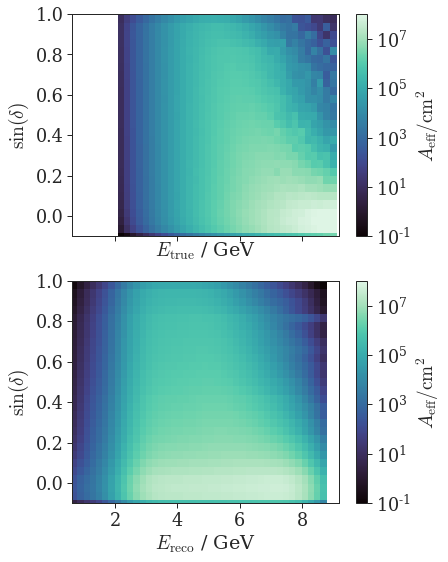

In [39]:
label = "10yr IceCube"

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,9))
im = ax1.pcolormesh(
    log_emids,
    sindec_bins,
    aeff_2d["IceCube"].T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax1, label=r"$A_{\rm eff} / \rm cm^2$")
ax1.set_ylim(-0.1, 1)
ax1.set_xlim(np.min(eri), 9.2)
ax1.set_xlabel(r"$E_{\rm true}$ / GeV")
ax1.set_ylabel(r"$\sin(\delta)$")
im = ax2.pcolormesh(
    eri,
    sindec_bins,
    np.dot(normed_kvals, aeff_2d["IceCube"]).T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax2, label=r"$A_{\rm eff} / \rm cm^2$")
ax2.set_ylim(-0.1, 1)
ax2.set_xlim(np.min(eri), 9.2)
ax2.set_xlabel(r"$E_{\rm reco}$ / GeV")
ax2.set_ylabel(r"$\sin(\delta)$")

### splining (not needed, but looks cool!)

In [17]:
e_ereco_splines = [InterpolatedUnivariateSpline(
    eri, kvals[:,i], k=1, ext=0
) for i,_ in enumerate(log_emids)]

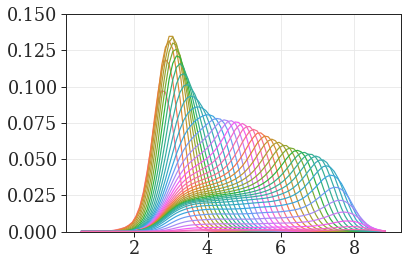

In [18]:
sns.set_palette("husl", n_colors=20)

# show test splines
er_test = calc_mids(np.arange(0.5, 9, 0.1))
for spl in e_ereco_splines:
    plt.plot(er_test, spl(er_test))
plt.ylim(0, 0.15)
## disco!!

sns.set_palette("colorblind", n_colors=4)

## test event numbers

original sum astro: 2337.4935266970087
smeared sum astro: 2337.493526697009 (should be the same)


Text(0, 0.5, '$\\sin(\\delta)$')

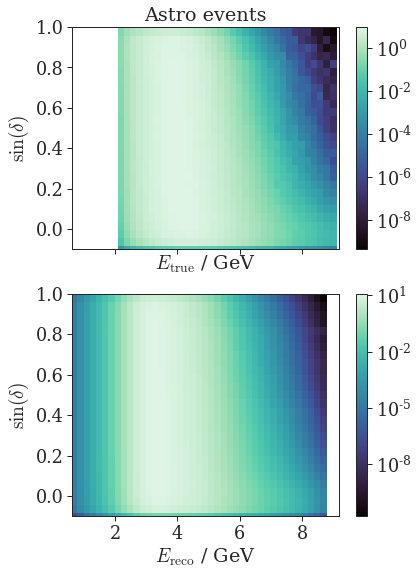

In [19]:
label = "10yr IceCube"
aeff_factor = aeff_eval_e_sd(aeff_2d[label.split(" ")[-1]]) * LIVETIME
astro_ev = aeff_factor * (emids/1E5)**(GAMMA_ASTRO) * PHI_ASTRO

print("original sum astro:", np.sum(astro_ev))
print("smeared sum astro:", np.sum(np.dot(normed_kvals, astro_ev.T)), "(should be the same)")


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,9))
im = ax1.pcolormesh(
    log_emids,
    sindec_bins,
    astro_ev,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax1)
ax1.set_ylim(-0.1, 1)
ax1.set_xlim(np.min(eri), 9.2)
ax1.set_title("Astro events")
ax1.set_xlabel(r"$E_{\rm true}$ / GeV")
ax1.set_ylabel(r"$\sin(\delta)$")
im = ax2.pcolormesh(
    eri,
    sindec_bins,
    np.dot(normed_kvals, astro_ev.T).T,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax2)
ax2.set_ylim(-0.1, 1)
ax2.set_xlim(np.min(eri), 9.2)
ax2.set_xlabel(r"$E_{\rm reco}$ / GeV")
ax2.set_ylabel(r"$\sin(\delta)$")

## Simple diffuse flux fit

In [20]:
# comparison data of official 10yr fit (Joeran's PhD thesis, to be published soon)
joeran_new = np.genfromtxt("../resources/joeran_phd_contour.txt")
joeran = np.genfromtxt("../resources/10yr_diffuse_ICRC2019.txt")


### with minimizer

In [21]:
from scipy.optimize import fmin_l_bfgs_b

### adapted from mauricio's notebook

## todo: broken powerlaw

In [22]:
## Adapted from Mauricio's fluxes

# These are the basic shapes
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2) )/(np.sqrt(2*np.pi) * sigma)

def power_law(energy, e_scale, gamma, phi0):
    return (energy/e_scale)**(gamma) * phi0

def cut_off(energy, e_cut):
    return np.exp(-energy/np.power(10, e_cut))

def parabola_index(alpha, beta, energy, enorm):
    return alpha + beta * np.log(energy/enorm)

def sigmoid(fraction_depletion, growth_rate, energy, energy_nu_trans):
    factor = 1 - fraction_depletion
    factor /= (1 + np.exp(-growth_rate * (energy - energy_nu_trans)))
    factor += fraction_depletion
    return factor

# combine basic shapes to actual fluxes

def astro_flux(shape, aeff_factor, emids, enorm, *args):
    """ 
    Wrapper for different astro flux shapes to put into TS minimizer.
    Possible shapes and their parameters:
    ° powerlaw:
        args[0]: gamma
        args[1]: phi scaling
        
    ° powerlaw * cutoff:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: cutoff energy
        
    ° powerlaw * dip/bump:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: amplitude --- sign of amplitude is defined by 'dip' or 'bump'
        args[3]: mean energy
        args[4]: width
        
    ° powerlaw * sigmoid:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: fraction of depletion
        args[3]: growth rate
        args[4]: transition energy
        
    ° log-parabola:
        args[0]: alpha parameter
        args[1]: phi scaling
        args[2]: beta parameter
    """
    
    if "powerlaw" in shape:
        _gamma_astro = args[0]
        _phi_astro_scaling = args[1]
        tmp =  aeff_factor * power_law(
            emids, enorm, _gamma_astro, PHI_0 * _phi_astro_scaling)
        
    if "cutoff" in shape:
        _energy_cut = args[2]
        tmp *= cut_off(emids, _energy_cut)
        
    if "bump" in shape or "dip" in shape:
        amp = np.power(10, args[2])
        energy_mean = np.power(10, args[3])
        sigma = np.power(10, args[4])
        amp = np.abs(amp) if "bump" in shape else -1 * np.abs(amp)
        tmp *= (1.0 + amp * gaussian(emids, energy_mean, sigma))
        
    if "sigmoid" in shape:
        fraction_depletion = np.power(10, args[2])
        growth_rate = np.power(10, args[3])
        energy_nu_trans = np.power(10, args[4])
        tmp *= sigmoid(fraction_depletion, growth_rate, emids, energy_nu_trans)
        
    if "parabola" in shape:
        _alpha_astro = args[0]
        _phi_astro_scaling = args[1]
        _beta_astro = args[2]        
        index = parabola_index(_alpha_astro, _beta_astro, emids, enorm)
        tmp =  aeff_factor * power_law(
            emids, enorm, index, PHI_0 * _phi_astro_scaling)
    return tmp

In [23]:
shape_params = {
    "powerlaw": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR]),
        "names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}"])
    },
    "powerlaw with cutoff": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, 6.5]),
        "names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}",
                  r"$\log_{10}$(Cut-off energy/GeV)"
                 ])},
    "powerlaw with sigmoid": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(0.1), np.log10(3E-5), np.log10(2E5)]),
        "names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}",
                  "Depletion fraction", "Growth rate", r"$\log_{10}$(Transition energy/GeV)"
                 ])},
    "powerlaw with dip": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(6E4), np.log10(2E5), np.log10(4E4)]),
        "names":np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}",
                  "Amplitude", r"$\log_{10}$(Mean energy/GeV)", r"$\log_{10}$(Width/GeV)"
                 ])},
    "powerlaw with bump": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(5E5), np.log10(2E5), np.log10(4E4)]),
        "names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}",
                  "Amplitude", r"$\log_{10}$(Mean energy/GeV)", r"$\log_{10}$(Width/GeV)"
                 ])},
    "log-parabola": {
        "baseline": np.array([1, -2, PHI_ASTRO_FACTOR, -0.2]),
        "names": np.array(["Conv. scaling", r"$\alpha$", r"$\Phi_0 / {\rm 10^-{18} GeV cm^2 s sr}", r"$\beta$"])}
}

for shape in shape_params:
    shape_params[shape]["guess"] = 0.95 * shape_params[shape]["baseline"]

#### plot exemplary shapes

10yr IceCube
10yr Plenum
10yr IceCube
10yr Plenum
10yr IceCube
10yr Plenum
10yr IceCube
10yr Plenum


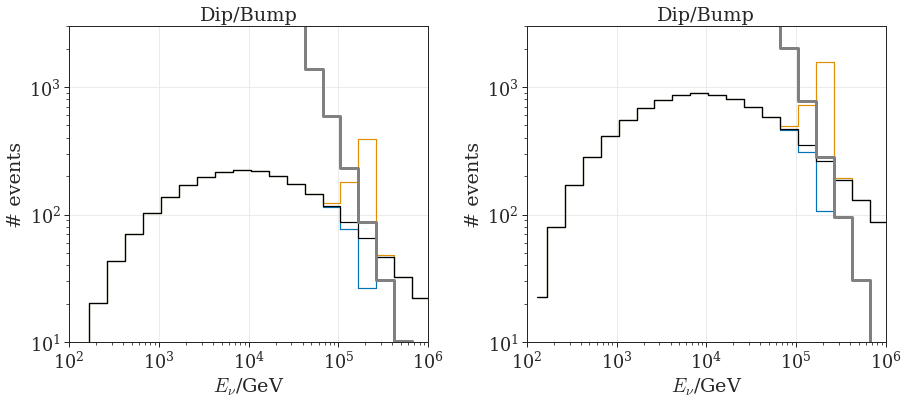

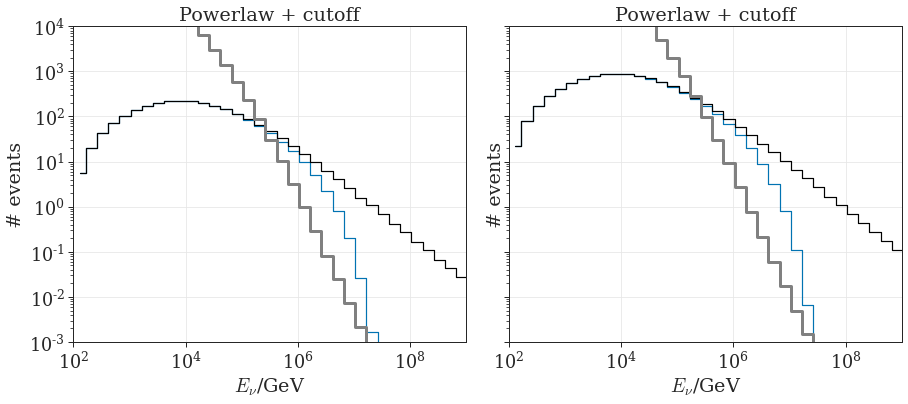

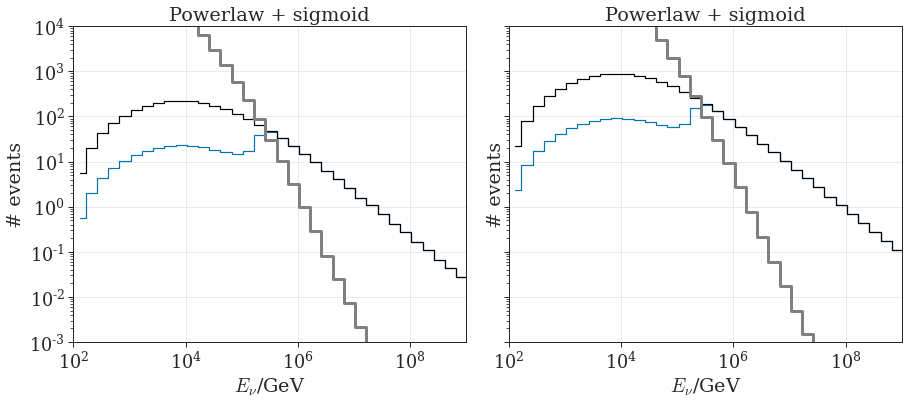

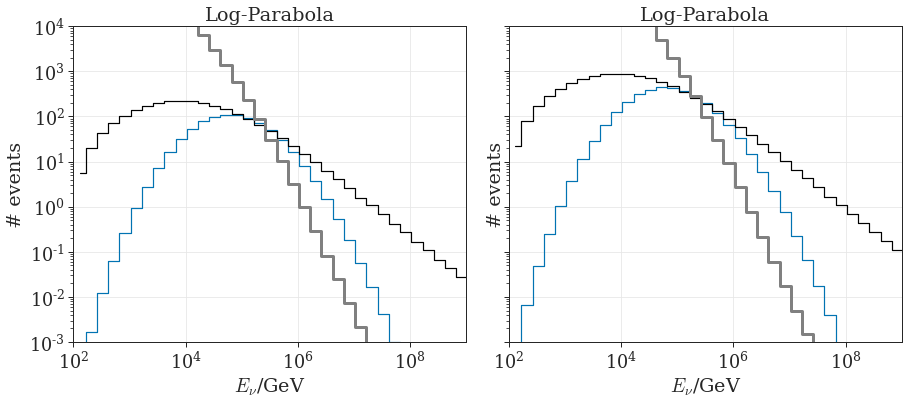

In [24]:

labels = ["10yr IceCube", "10yr Plenum"]

f, axes = plt.subplots(ncols=2, figsize=(13, 6))
for i, label in enumerate(labels):
    ax = axes[i]
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw with dip", aeff_factor, emids, 1E5, *shape_params["powerlaw with dip"]["baseline"][1:]), axis=0),
           drawstyle="steps-mid") # amplitude, mean energy, width
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw with bump", aeff_factor, emids, 1E5, *shape_params["powerlaw with bump"]["baseline"][1:]), axis=0),
           drawstyle="steps-mid") # amplitude, mean energy, width
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw", aeff_factor, emids, 1E5, *shape_params["powerlaw"]["baseline"][1:]), axis=0), color="black",
           drawstyle="steps-mid")
    ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals, axis=0),
            label="Conv., Truth",
            lw=3,
            color="gray",
        drawstyle="steps-mid"
        )
    ax.set_title("Dip/Bump")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(10, 3E3)
    ax.set_xlim(100, 1E6)
    ax.set_ylabel(r"# events")
    ax.set_xlabel(r"$E_\nu$/GeV")
f.tight_layout()

f, axes = plt.subplots(ncols=2, figsize=(13, 6), sharey=True)
for i, label in enumerate(labels):
    ax = axes[i]
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw cutoff", aeff_factor, emids, 1E5, *shape_params["powerlaw with cutoff"]["baseline"][1:]), axis=0),
           drawstyle="steps-mid")
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw", aeff_factor, emids, 1E5, *shape_params["powerlaw"]["baseline"][1:]), axis=0), color="black",
           drawstyle="steps-mid")
    ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals, axis=0),
            label="Conv., Truth",
            lw=3,
            color="gray",
           drawstyle="steps-mid"
        )
    ax.set_title("Powerlaw + cutoff")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1e-3, 1E4)
    ax.set_xlim(100, 1E9)
    ax.set_ylabel(r"# events")
    ax.set_xlabel(r"$E_\nu$/GeV")
f.tight_layout()

f, axes = plt.subplots(ncols=2, figsize=(13, 6), sharey=True)
for i, label in enumerate(labels):
    ax = axes[i]
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw with sigmoid", aeff_factor, emids, 1E5, *shape_params["powerlaw with sigmoid"]["baseline"][1:]), axis=0),
           drawstyle="steps-mid") # depletion, growth, transition
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw", aeff_factor, emids, 1E5, *shape_params["powerlaw"]["baseline"][1:]), axis=0), color="black",
           drawstyle="steps-mid")
    ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals, axis=0),
            label="Conv., Truth",
            lw=3,
            color="gray",
           drawstyle="steps-mid"
        )
    ax.set_title("Powerlaw + sigmoid")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1e-3, 1E4)
    ax.set_xlim(100, 1E9)
    ax.set_ylabel(r"# events")
    ax.set_xlabel(r"$E_\nu$/GeV")
f.tight_layout()

f, axes = plt.subplots(ncols=2, figsize=(13, 6), sharey=True)
for i, label in enumerate(labels):
    ax = axes[i]
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    ax.plot(emids, np.sum(astro_flux(
        "log-parabola", aeff_factor, emids, 1E5, *shape_params["log-parabola"]["baseline"][1:]), axis=0),
           drawstyle="steps-mid") # alpha phi beta
    ax.plot(emids, np.sum(astro_flux(
        "powerlaw", aeff_factor, emids, 1E5, *shape_params["powerlaw"]["baseline"][1:]), axis=0), color="black",
           drawstyle="steps-mid")
    ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals, axis=0),
            label="Conv., Truth",
            lw=3,
            color="gray",
           drawstyle="steps-mid"
        )
    ax.set_title("Log-Parabola")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1e-3, 1E4)
    ax.set_xlim(100, 1E9)
    ax.set_ylabel(r"# events")
    ax.set_xlabel(r"$E_\nu$/GeV")

f.tight_layout()

In [25]:
def spectral_ts_func(x, aeff_factor, emids, enorm, shape="powerlaw", verbose=False):
    """First parameter is always conv scaling, rest is defined in astro_flux()"""
    # free parameters
    _conv_scaling = x[0]
    # astro events with single powerlaw
    astro_ev = astro_flux(shape, aeff_factor, emids, enorm, *x[1:])
    if verbose:
        print(x)
        print(*x[1:])
        print(np.sum(astro_ev))
    # atm events based on MCEQ with scaling factor
    atm_ev = aeff_factor * spl_vals * _conv_scaling

    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # this defines the LLH function with free parameters
    all_mu_i = astro_ev + atm_ev
    return -2 * np.sum(
        np.where(
            all_mu_i > 0,
            k_i * np.log(all_mu_i) - all_mu_i \
                - 0.5 * np.log(2*np.pi*k_i) + k_i - k_i * np.log(k_i),
            0)
    )

In [26]:
def local_ts_func(x, fixed_params, free_positions, fixed_params_positions, *args):
    r""" Reduce full likelihood function with fixed parameters, i.e. reduce to
    a 'local' likelihood function. Free and fixed parameters are combined in one
    array to be piped through to 'spectral_ts_func'.
    -----------------------------------------------------------------------
    
    x: free parameters, piped through to 'spectral_ts_func'
    fixed_params: value of fixed parameters
    free_positions: array indices of free parameters
    fixed_params_positions: array indices of fixed parameters
    *args: piped through to 'spectral_ts_func'
    
    returns spectral_ts_func(free_and_fixed_parameters, *args)
    """
    all_x = np.zeros(len(x) + len(fixed_params))
    for i, pos in enumerate(fixed_params_positions):
        all_x[pos] = fixed_params[i]
    for i, pos in enumerate(free_positions):
        all_x[pos] = x[i]
    return spectral_ts_func(all_x, *args)

### loop through all shapes

powerlaw
10yr IceCube
baseline astro ev 2337.4935266970087
asimov param:  [ 1.   -2.28  1.44]
bf param: [ 1.00000021 -2.2799899   1.43983002]
is close (truth vs fit): [ True  True  True]
is close (guess vs fit): [False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 9348.156419418276
asimov param:  [ 1.   -2.28  1.44]
bf param: [ 1.00000001 -2.28000452  1.440009  ]
is close (truth vs fit): [ True  True  True]
is close (guess vs fit): [False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


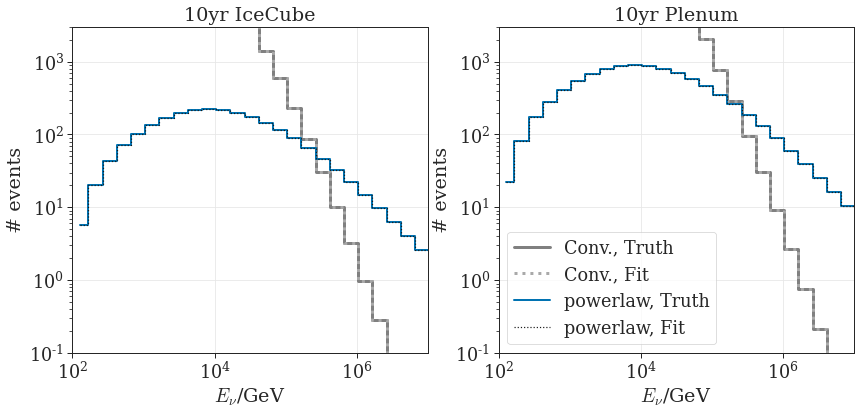

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with cutoff
10yr IceCube
baseline astro ev 2281.0674527163437
asimov param:  [ 1.   -2.28  1.44  6.5 ]
bf param: [ 0.99999592 -2.28082066  1.43935367  6.50237893]
is close (truth vs fit): [ True  True  True  True]
is close (guess vs fit): [False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 9122.45681344797
asimov param:  [ 1.   -2.28  1.44  6.5 ]
bf param: [ 1.00026288 -2.22093767  1.53955407  6.29400938]
is close (truth vs fit): [ True False False False]
is close (guess vs fit): [False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


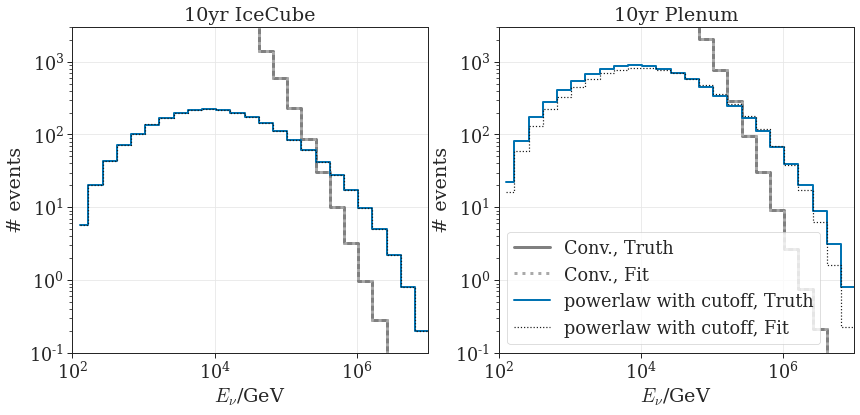

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with sigmoid
10yr IceCube
baseline astro ev 411.87622785123216
asimov param:  [ 1.         -2.28        1.44       -1.         -4.52287875  5.30103   ]
bf param: [ 1.00003578 -2.2766496   1.41311534 -1.01397104 -4.28936848  5.2767713 ]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 1647.2923789313809
asimov param:  [ 1.         -2.28        1.44       -1.         -4.52287875  5.30103   ]
bf param: [ 1.00005106 -2.24513296  1.25883548 -0.98370066 -4.28335372  5.20547118]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


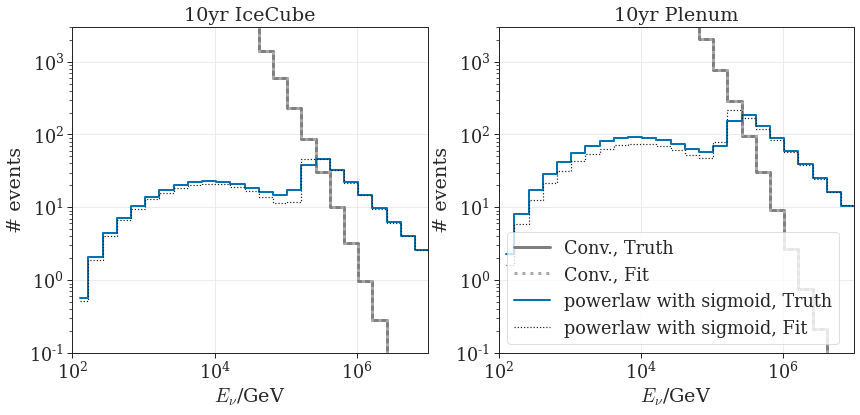

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with dip
10yr IceCube
baseline astro ev 2286.153079706043
asimov param:  [ 1.         -2.28        1.44        4.77815125  5.30103     4.60205999]
bf param: [ 1.00001145 -2.28352052  1.43137091  4.53005754  5.11507585  4.35367358]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 9142.825268892848
asimov param:  [ 1.         -2.28        1.44        4.77815125  5.30103     4.60205999]
bf param: [ 1.00000639 -2.28366437  1.43008596  4.52570845  5.11882137  4.345002  ]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


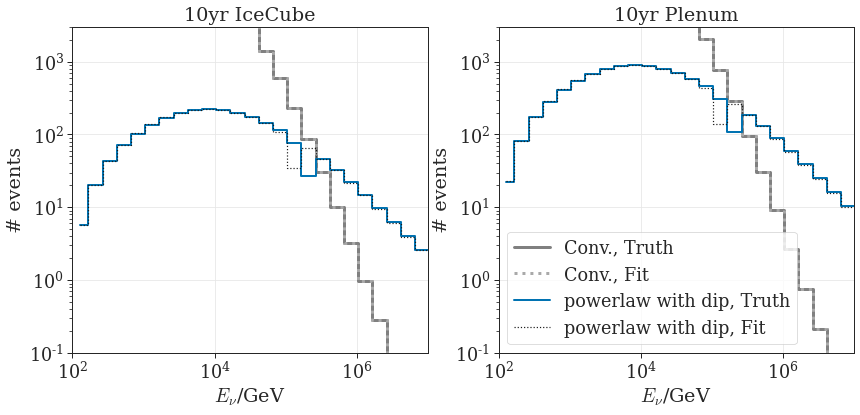

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with bump
10yr IceCube
baseline astro ev 2765.330584955053
asimov param:  [ 1.         -2.28        1.44        5.69897     5.30103     4.60205999]
bf param: [ 0.99986156 -2.28955476  1.48610886  5.5980427   5.27658057  4.35649981]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 11059.249340463502
asimov param:  [ 1.         -2.28        1.44        5.69897     5.30103     4.60205999]
bf param: [ 0.99986698 -2.28925358  1.48422736  5.59573396  5.27916422  4.38106492]
is close (truth vs fit): [ True False False False False False]
is close (guess vs fit): [False False False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


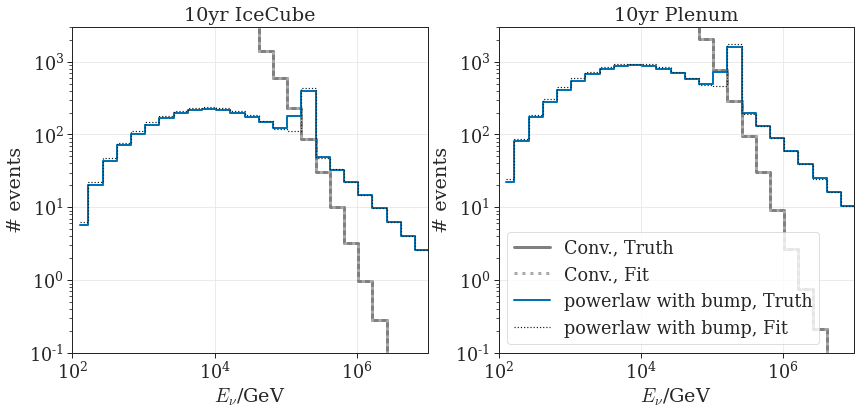

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
log-parabola
10yr IceCube
baseline astro ev 784.4425222068107
asimov param:  [ 1.   -2.    1.44 -0.2 ]
bf param: [ 1.00003771 -1.96854788  1.45496047 -0.21554843]
is close (truth vs fit): [ True False False False]
is close (guess vs fit): [False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 3137.278940180408
WARNING!!
asimov param:  [ 1.   -2.    1.44 -0.2 ]
bf param: [-0.09421804 -2.01838144  1.45018394 -0.28799934]
is close (truth vs fit): [False False False False]
is close (guess vs fit): [False False False False]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


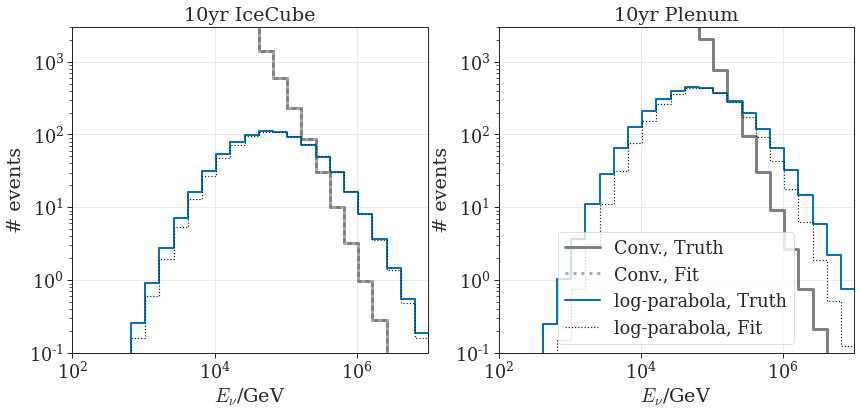

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [27]:
labels = ["10yr IceCube", "10yr Plenum"]
for shape in shape_params:
    print(shape)
    f, axes = plt.subplots(ncols=2, figsize=(14, 6))
    
    for li, label in enumerate(labels):
        print(label)
        ident = label.split(" ")[-1]
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME

        # calculate asimov 'data' = expectation of perfect experiment
        astro_ev = astro_flux(shape, aeff_factor, emids, 1E5, *shape_params[shape]["baseline"][1:])
        print("baseline astro ev", np.sum(astro_ev))
        atm_ev = aeff_factor * spl_vals * shape_params[shape]["baseline"][0]
        # energy smearing
        # dimension energy x sindec
        astro_ev = (normed_kvals @ astro_ev.T).T
        atm_ev = (normed_kvals @ atm_ev.T).T
        # asimov = expectation of perfect experiment
        k_i = astro_ev + atm_ev    

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            approx_grad=True,
            args=(aeff_factor, emids, 1E5, shape)
        )
        #print("fit status:", out[2])
        if out[2]['warnflag'] != 0:
            print("WARNING!!")
        print("asimov param: ", shape_params[shape]["baseline"])
        print("bf param:", out[0])
        print("is close (truth vs fit):", np.isclose(shape_params[shape]["baseline"], out[0], rtol=1e-3))
        print("is close (guess vs fit):", np.isclose(shape_params[shape]["guess"], out[0], rtol=1e-3))
        #print("TS:", out[1])
        print("* *"*20)
        
        ax = axes[li]
        ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals * shape_params[shape]["baseline"][0], axis=0),
            label="Conv., Truth",
            lw=3,
            color="gray",
           drawstyle="steps-mid"
        )
        ax.plot(
            emids, 
            np.sum(aeff_factor * spl_vals * out[0][0], axis=0),
            label="Conv., Fit",
            lw=3,
            color="darkgray",
            ls=":",
           drawstyle="steps-mid"
        )
        ax.plot(
            emids, 
            np.sum(astro_flux(
                shape, aeff_factor, emids, 1E5, *shape_params[shape]["baseline"][1:]), axis=0),
            label=shape + ", Truth",
            lw=2,
           drawstyle="steps-mid"
        )
        ax.plot(
            emids, 
            np.sum(astro_flux(
                shape, aeff_factor, emids, 1E5, *out[0][1:]), axis=0),
            label=shape + ", Fit",
            ls=":",
            color="k",
           drawstyle="steps-mid"
        )
        ax.set_title(label)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylim(1e-1, 3E3)
        ax.set_xlim(100, 1E7)
        ax.set_ylabel(r"# events")
        ax.set_xlabel(r"$E_\nu$/GeV")
    plt.legend()
    plt.show()
    print("- -"*20)

## exemplary 1D scan with cutoff

In [28]:
E_CUT = 6.5

10yr IceCube
baseline astro ev 2281.0674527163437
asimov param:  -2.28 1.44 6.5
guess param:  0.95 -2.166 1.3679999999999999 6.175
bf param: [ 0.99999592 -2.28082066  1.43935367  6.50237893]
TS: -748.5999220788035
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
10yr Plenum
baseline astro ev 9122.45681344797
asimov param:  -2.28 1.44 6.5
guess param:  0.95 -2.166 1.3679999999999999 6.175
bf param: [ 1.00026288 -2.22093767  1.53955407  6.29400938]
TS: 868.1796037436352
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *


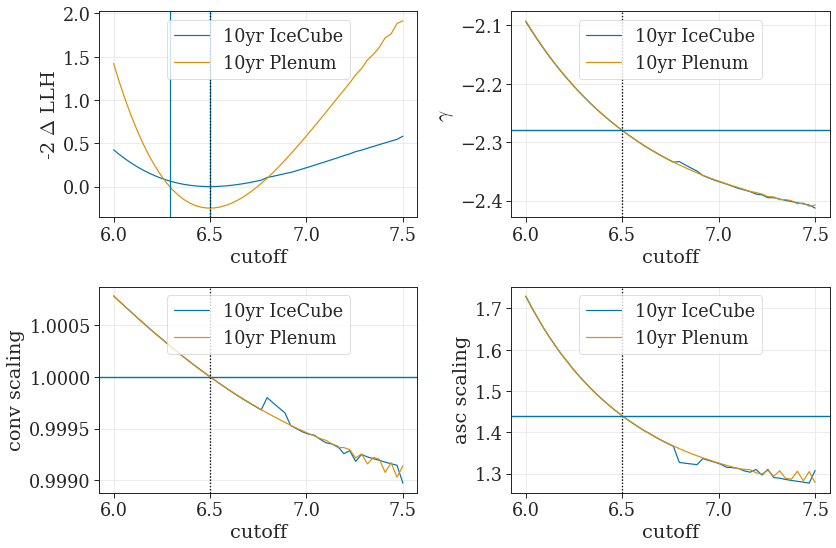

In [29]:
labels = ["10yr IceCube", "10yr Plenum"]
num = 50
cutoff = np.linspace(6, 7.5, num=num)
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    shape = "powerlaw with cutoff"
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    # calculate asimov 'data' = expectation of perfect experiment
    astro_ev = astro_flux(shape, aeff_factor, emids, 1E5, *shape_params[shape]["baseline"][1:])
    print("baseline astro ev", np.sum(astro_ev))
    atm_ev = aeff_factor * spl_vals * shape_params[shape]["baseline"][0]
    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # asimov = expectation of perfect experiment
    k_i = astro_ev + atm_ev    

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, 1E5, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    print("asimov param: ", *shape_params[shape]["baseline"][1:])
    print("guess param: ", *shape_params[shape]["guess"])
    print("bf param:", out[0])
    print("TS:", out[1])
    print("* *"*20)

    local_ts_min = np.zeros(num)
    local_param_min = {
        "gamma": np.zeros(num),
        "conv": np.zeros(num),
        "asc": np.zeros(num)
    }
    for i, cc in enumerate(cutoff):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=shape_params[shape]["guess"][:3],
            approx_grad=True,
            args=([cc], (0, 1, 2), (3,), aeff_factor, emids, 1E5, shape)
        )
        local_param_min["conv"][i], local_param_min["gamma"][i], local_param_min["asc"][i] = local_out[0]
        local_ts_min[i] = local_out[1]
        
    ax = axes[0][0]
    ax.plot(cutoff, local_ts_min- out[1], label=label) #- out[1]
    ax.set_ylabel(r"-2 $\Delta$ LLH")
    ax.set_xlabel("cutoff")
    ax.legend(loc='upper center')
    ax.axvline(E_CUT, color="k", ls=":")
    ax.axvline(out[0][-1])
    
    ax = axes[0][1]
    ax.set_ylabel(r"$\gamma$")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["gamma"], label=label)
    ax.legend(loc='upper center')
    ax.axvline(E_CUT, color="k", ls=":")
    ax.axhline(GAMMA_ASTRO)
    
    ax = axes[1][0]
    ax.set_ylabel(r"conv scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["conv"], label=label)
    ax.legend(loc='upper center')
    ax.axvline(E_CUT, color="k", ls=":")
    ax.axhline(1)
    
    
    ax = axes[1][1]
    ax.set_ylabel(r"asc scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["asc"], label=label)
    ax.legend(loc='upper center')
    ax.axvline(E_CUT, color="k", ls=":")
    ax.axhline(PHI_ASTRO_FACTOR)
f.tight_layout()

## 2D scan powerlaw

In [30]:
labels = ["10yr IceCube", "10yr Plenum"]
ts_mins = {}
local_ts_mins = {}
local_conv_mins = {}
gamma_mins = {}
phi_astro_mins = {}

num = 30
gamma_astro_scaling = np.linspace(-1.9, -2.7, num=num+1)
astro_scaling = np.linspace(0.4, 2.6, num=num)

shape = "powerlaw"
for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    
    # calculate asimov 'data' = expectation of perfect experiment
    astro_ev = astro_flux(shape, aeff_factor, emids, 1E5, *shape_params[shape]["baseline"][1:])
    print("baseline astro ev", np.sum(astro_ev))
    atm_ev = aeff_factor * spl_vals * shape_params[shape]["baseline"][0]
    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # asimov = expectation of perfect experiment
    k_i = astro_ev + atm_ev    

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, 1E5, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])
    
    ts_min = out[1]
    gamma_mins[label] = out[0][1]
    phi_astro_mins[label] = out[0][2]
    
    local_ts_min = np.zeros((num, num+1))
    local_conv_min = np.zeros((num, num+1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=([gas, asc], (0, ), (1, 2), aeff_factor, emids, 1E5, shape)
            )
            local_conv_min[i][j], = local_out[0]
            local_ts_min[i][j] = local_out[1]

    print("done")
    ts_mins[label] = ts_min
    local_ts_mins[label] = local_ts_min
    local_conv_mins[label] = local_conv_min

10yr IceCube
baseline astro ev 2337.4935266970087
asimov param:  [ 1.   -2.28  1.44]
bf param: [ 1.00000021 -2.2799899   1.43983002]
starting local fits...
done
10yr Plenum
baseline astro ev 9348.156419418276
asimov param:  [ 1.   -2.28  1.44]
bf param: [ 1.00000001 -2.28000452  1.440009  ]
starting local fits...
done


10yr IceCube
10yr Plenum


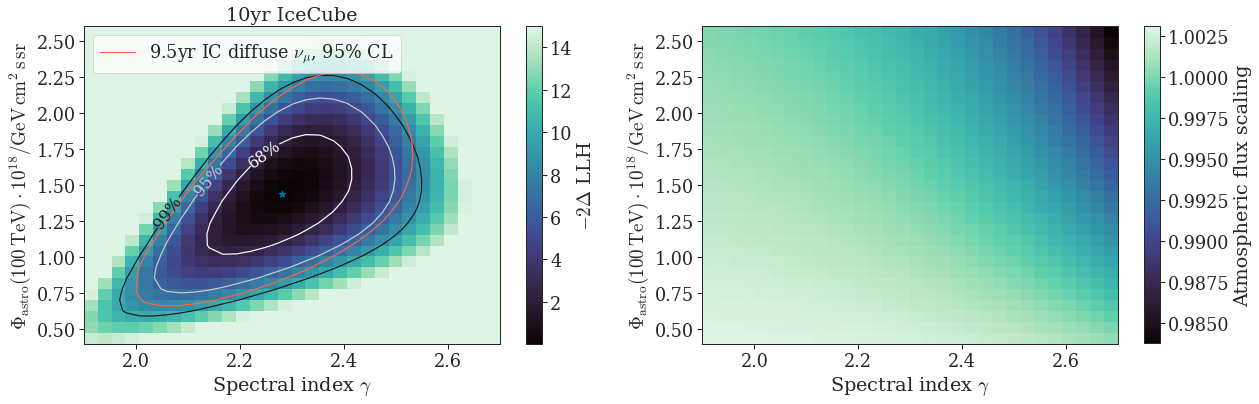

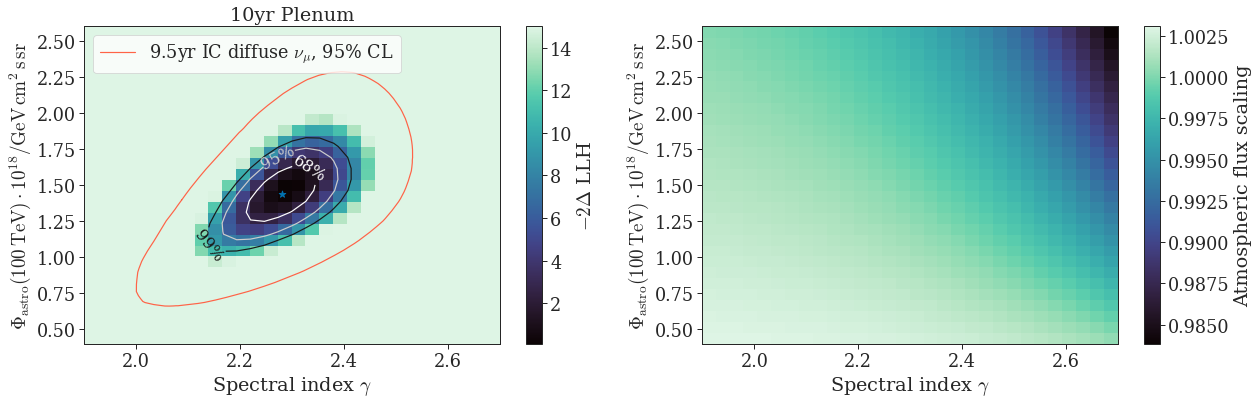

In [32]:
for label in labels:
    print(label)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling,
        local_ts_mins[label] - ts_mins[label],
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling,
        local_ts_mins[label] - ts_mins[label],
        levels=levels,
        colors=["w", "0.8", "k"]
        #cmap=plt.cm.gray_r
    )
    ax.scatter(-gamma_mins[label], phi_astro_mins[label], marker="*", s=50)
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # correctly sort extracted contour from joeran's latest diffuse fit
    idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
    xx = joeran[:,0][idx]
    xx = np.concatenate([[xx[-1]], xx])
    yy = joeran[:,1][idx]
    yy = np.concatenate([[yy[-1]], yy])
    ax.plot(xx, yy, color="tomato", label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL")
    ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(label)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling,
        local_conv_mins[label],
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")

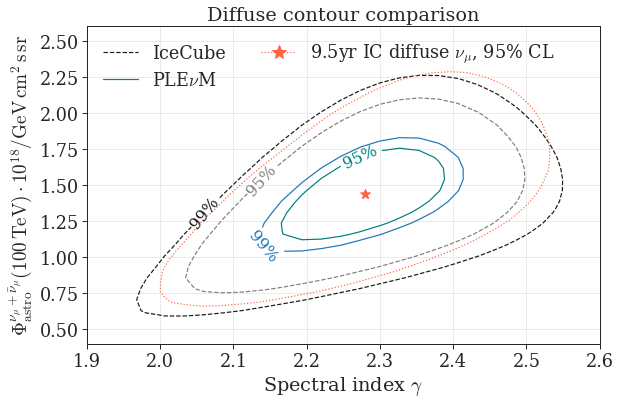

In [44]:
f, ax = plt.subplots(figsize=(9, 6))
## correctly sort extracted contour from joeran's latest diffuse fit
idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
xx = joeran[:,0][idx]
xx = np.concatenate([[xx[-1]], xx])
yy = joeran[:,1][idx]
yy = np.concatenate([[yy[-1]], yy])
ax.plot(xx, yy, color="tomato", ls=":")

for label in labels:
    # draw contour levels
    cvals = np.array([0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling,
        local_ts_mins[label] - ts_mins[label],
        levels=levels,
        colors=["gray", "k"] if "IceCube" in label else ["teal", "tab:blue"],
        linestyles="--" if "IceCube" in label else "-"
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # best fit
    ax.scatter(-gamma_mins[label], phi_astro_mins[label], marker="*", s=100, color="tomato")
lines = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="k",
        ls="--",
    ),
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="teal",
        ls="-",
    ),
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="tomato",
        ls=":",
        marker="*",
        markersize=15
    )
]
ax.set_ylim(0.4, 2.6)
ax.set_xlim(1.9, 2.6)
ax.legend(lines, ["IceCube", r"PLE$\nu$M", r"9.5yr IC diffuse $\nu_\mu$, 95% CL"], loc=2, ncol=2, frameon=False)
ax.set_ylabel(r"$\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}(100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse contour comparison")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")

# IN WORK -- spatial template fits

# Dipole

Auger: "dipole with an amplitude of $6.5^{+1.3}_{−0.9}\%$ towards right ascension $\alpha_d=100\pm10$ degrees and declination $\delta_d=−24^{+12}_{−13}$ degrees"

https://arxiv.org/abs/1709.07321

### define dipole template

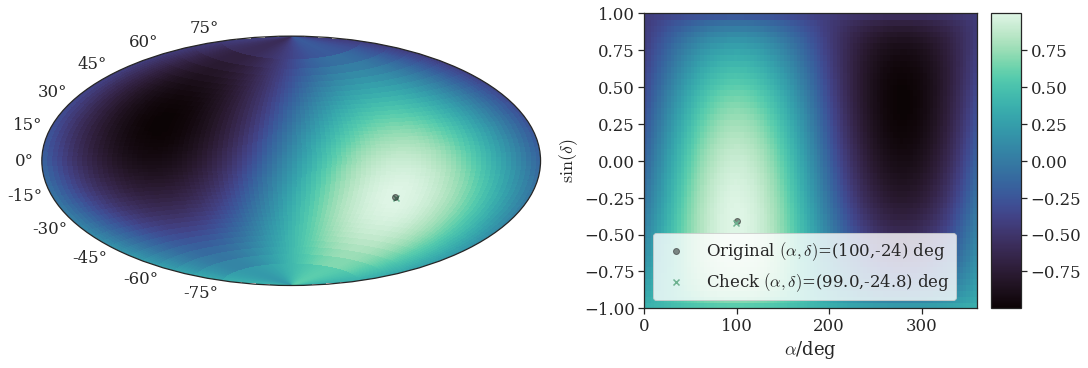

In [100]:
A_base = 0.065 # dipole amplitude

# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(constrained_layout=True, figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(
    *np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
)
ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
im = ax2.pcolormesh(
    *np.meshgrid(np.rad2deg(ra_bins), sindec_bins),
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30, use_gridspec=True)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)
fig.savefig("../plots/dipole_test.pdf")

### energy x sindec x RA

final shape: (40, 100, 50)  = energy x ra x sindec
IceCube
conv events: 628697.8635643641
astro events: 2729.369841874679
final shape: (40, 100, 50)  = energy x ra x sindec
Plenum
conv events: 2527942.609780368
astro events: 10915.255455828335


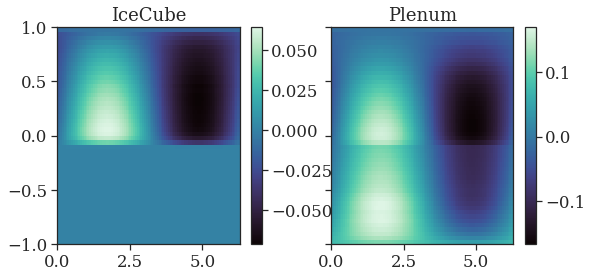

In [102]:
fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)
# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y


# check
for ii, det in enumerate(["IceCube", "Plenum"]):
    aeff_factor = ((aeff_2d[det] * sindec_width).T * ewidth)[:,:,np.newaxis] * LIVETIME * np.atleast_2d(ra_width)
    # #  effectively factor of 1, distributed over the RA binning
    # aeff_factor dimension: sindec x energy x ra
    

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(GAMMA_ASTRO) * PHI_ASTRO, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    print("final shape:", np.shape(astro_ev), " = energy x ra x sindec")

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))
    
    dipole_evs = astro_ev * A_base * dipole
    ax = axes[ii]
    ax.set_title(det)
    p = ax.pcolormesh(
        ra_bins,
        sindec_bins, 
        dipole_evs.sum(axis=0).T,
    )
    cb = fig.colorbar(p,ax=ax)

# template fit

# NOTE: maximum dipole amplitude is 50\%, otherwise there will be negative astro flux

* fixed dipole axis
* scan over dipole strength as free parameter
* astro normalization as additional nuisance parameter
* no systematic uncertainties
* asimov data (k_i == mu_i)

$\Lambda(data|hypothesis) = \prod_{bins\,i} \frac{\mu_i^{k_i}}{k_i!} \exp(-\mu_i)$

Signal: $\mu_i(H_1) = \mu_i^S + \mu_i^B$ defined by dipole amplitude

Background: $\mu_i(H_0) = \mu_i^B$ dipole amplitude = 0

Asimov data: $k_i = \mu_i(H_1)$

$\log(\Lambda_i) = k_i \cdot \log \mu_i - \log k_i! - \mu_i$

Test statistic: $-2\Delta LLH = -2 \left( \sum_{bins\,i} \log \Lambda_i ( H_{scan}) - \log \Lambda_i (H_{bf}) \right)$ 

# construct likelihood ratio test against best-fit LLH

# $-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$

## Amplitude scan only

* MCEq fixed
* Astro parameters fixed


10yr IceCube
total events with dipole: 12624357.643187111
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37
10yr Plenum
total events with dipole: 50763722.46823402
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan only')

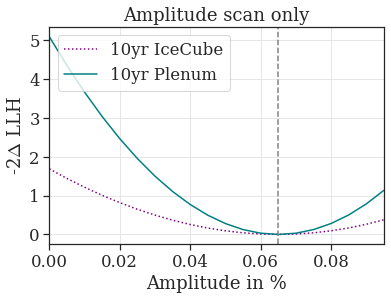

In [61]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.atleast_1d(1) # np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

f, ax = plt.subplots()

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.set_title("Amplitude scan only")

In [62]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## Amplitude scan, and phi_astro as nuisance

10yr IceCube
total events with dipole: 378730729.29561067
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37
10yr Plenum
total events with dipole: 1522911674.0470195
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan + $\\Phi_0^{\\rm astro}$ nuisance')

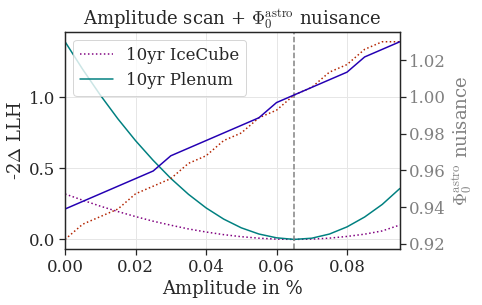

In [63]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )
    tmp_astro = 0
    all_mu_i = 0
    k_i = 0

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

    # get bf nuisance parameters
    prf_ind_asc, prf_ind_gsc = np.unravel_index(np.argmin(llh_s.reshape(-1, llh_s.shape[-1]), axis=0), shape=llh_s.shape[:2])
    astro_nuis[label] = astro_scaling[prf_ind_asc]
    gamma_nuis[label] = g_scaling[prf_ind_gsc]

f, ax = plt.subplots()

ax2 = ax.twinx()
ax2.set_ylabel(r"$\Phi_0^{\rm astro}$ nuisance", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.grid(False)

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    ax2.plot(
        A_scaling,
        astro_nuis[label],
        color=slightly_change_color(plot_sets[label]["color"]),
        ls=plot_sets[label]["ls"]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")

In [64]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## what amplitude could be visible?

## with astro scaling

In [65]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.25, step=0.01)
astro_scaling = np.linspace(0.7, 1.1, 40) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)

10yr IceCube
total events with dipole: 580527848.6671963
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359]
Phi bckg scaling best-fit [0.97692308 0.96666667 0.95641026 0.94615385 0.92564103 0.91538462
 0.90512821 0.89487179 0.88461538 0.87435897 0.85384615 0.84358974
 0.83333333 0.82307692 0.81282051 0.8025641  0.79230769 0.77179487
 0.76153846 0.75128205 0.74102564 0.73076923 0.72051282]
10yr Plenum
total events with dipole: 2334513234.394273
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.997

In [66]:
all_mu_i = 0
bg_mu_i = 0
k_i = 0
llh_s = 0
llh_b = 0

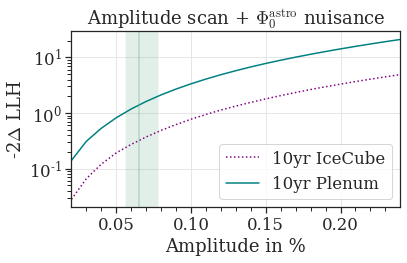

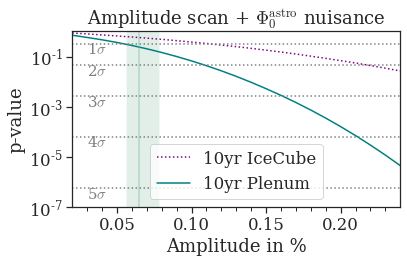

In [67]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_pval.pdf")

## without astro scaling

In [68]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.2, step=0.01)
astro_scaling = np.atleast_1d(1) #np.linspace(0.9, 1.1, 30) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)

10yr IceCube
total events with dipole: 11359602.913952438
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10yr Plenum
total events with dipole: 45679909.42903548
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [69]:
all_mu_i = 0
bg_mu_i = 0
llh_s = 0
llh_b = 0

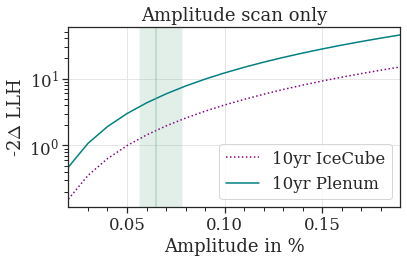

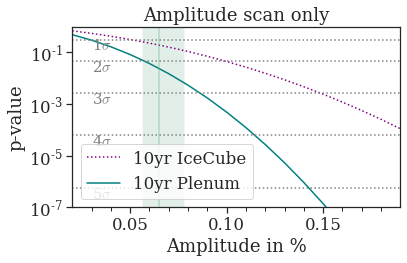

In [70]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan only")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_only_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan only")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_only_pval.pdf")

## Galactic Center + Galactic Plane

In [71]:
from core.tools import ang_dist

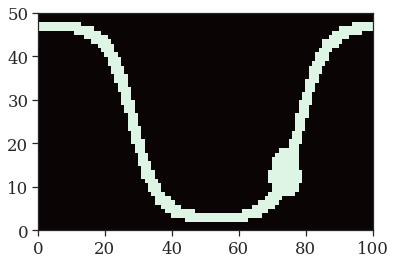

In [72]:
gc_temp = np.zeros((len(ra_mids), len(sindec_mids)))
r, d = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
coords = SkyCoord(r, d, unit='rad', frame='icrs')
lg = coords.galactic.l.rad
bg = coords.galactic.b.rad
ang_unc = ang_dist(0.,0., lg, bg)
mask_template_gc = ang_unc < np.deg2rad(15.)
mask_template_gp = np.abs(bg) < np.deg2rad(5.)
gc_temp[(mask_template_gc | mask_template_gp).T] = 1

plt.pcolormesh(gc_temp.T)

In [92]:
gp_base_norm = 3E-18
gp_base_gamma = -2.5
gp_norm_scaling = np.linspace(0.7, 1.1, 40)
astro_scaling = np.linspace(0.7, 1.1, 40)
gamma_gp_scaling = np.linspace(-2, -3.5, 25)
phi_astro_scaler = 0.78

# GC + GP
gc_temp = np.zeros((len(ra_mids), len(sindec_mids)))
r, d = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
coords = SkyCoord(r, d, unit='rad', frame='icrs')
lg = coords.galactic.l.rad
bg = coords.galactic.b.rad
ang_unc = ang_dist(0.,0., lg, bg)
mask_template_gc = ang_unc < np.deg2rad(15.)
mask_template_gp = np.abs(bg) < np.deg2rad(5.)
gc_temp[(mask_template_gc | mask_template_gp).T] = 1
gc_temp = gc_temp[:,:,np.newaxis]

# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))
uni = uni[:,:,np.newaxis]


llh_global_min = dict()
llh_scan_min = dict()
conv_nuis = dict()
gamma_nuis = dict()
llh_s = dict()

# KRA-$\gamma$ template

In [59]:
import tables

In [60]:
gaggeroFile = r"../resources/gaggero_KRAgamma_hardening_5e7_neutrino_COGalprop_HIGalprop_healpix.V2_hd5"
hdf = tables.open_file(gaggeroFile)
flux = hdf.root.flux.col("value")

In [70]:
hdf.root.flux.cols

/flux.cols (Cols), 1 columns
  value (Column(33619968,), float64)